In [1]:

# Modified script content with additional tuning, early stopping, and class distribution checks.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import joblib

In [2]:
#import the tensoflow libarys, these handel the the test/train split of the data, the model creation and the model comparison
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, Concatenate, Multiply
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K
from tensorboard import notebook
import os
import datetime
import os
import datetime
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from tensorflow.keras.layers import Input, Dense, Dropout, Multiply
from tensorflow.keras import backend as K


In [3]:
# Load the data
df = pd.read_csv('C:/Users/honey/Documents/placment work/Electronical-AI-Device-Recogniser/khanya/data managment/datasets/acs-f2-dataset.csv')

In [4]:

# Drop the 'time' column as it's not relevant for prediction
df = df.drop('time', axis=1)


In [5]:
# Convert categorical labels to numeric
le = LabelEncoder()
df['equipment'] = le.fit_transform(df['equipment'])

# Split features and labels
X = df.drop('equipment', axis=1)
y = df['equipment']

# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# One-hot encode the labels
y_resampled_onehot = to_categorical(y_resampled)

# Split the resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled_onehot, test_size=0.2, random_state=42)

In [6]:

# Define the model architecture with weighted inputs and dropout
input_layer = Input(shape=(X_train.shape[1],))

# Define weights for each input feature
weights = K.constant([[4.0, 2.0, 1.5, 1.0, 0.5, 0.2]])  # Adjust these weights as needed

# Apply the weights to the input features
weighted_inputs = Multiply()([input_layer, weights])

# Add hidden layers
x = Dense(64, activation='relu')(weighted_inputs)
x = Dropout(0.5)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(y_train.shape[1], activation='softmax')(x)

# Create the model
model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)

# Compile the model with a lower learning rate for better generalization
initial_learning_rate = 0.0005
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,
    decay_rate=0.96,
    staircase=True
)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# TensorBoard for logging

logdir = os.path.join("logs")
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)



# Train the model with early stopping, TensorBoard callback, and model checkpoint
history = model.fit(X_train, y_train, 
                    validation_data=(X_test, y_test),
                    epochs=100, 
                    batch_size=128, 
                    callbacks=[early_stopping, tensorboard_callback])


Epoch 1/100
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.0682 - loss: 45.8596 - val_accuracy: 0.0655 - val_loss: 2.7088
Epoch 2/100
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.0690 - loss: 2.9797 - val_accuracy: 0.0655 - val_loss: 2.7082
Epoch 3/100
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.0679 - loss: 2.7766 - val_accuracy: 0.0655 - val_loss: 2.7081
Epoch 4/100
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.0660 - loss: 2.7313 - val_accuracy: 0.0655 - val_loss: 2.7082
Epoch 5/100
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.0666 - loss: 2.7186 - val_accuracy: 0.0647 - val_loss: 2.7082
Epoch 6/100
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.0668 - loss: 2.7148 - val_accuracy: 0.0647 - val_loss: 2.7082
Epoch 7/100
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.0667 - loss: 2.7118 - val_accuracy: 0.0650 - val_loss: 2.7081
Epoch 8/100
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.0670 - loss: 

In [23]:
import os
logs = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
print(logdir)


logs


In [8]:
import tensorboard

In [22]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [21]:
%reload_ext tensorboard

In [32]:
%tensorboard --logdir=/logs

1011/1011 ━━━━━━━━━━━━━━━━━━━━ 1s 657us/step


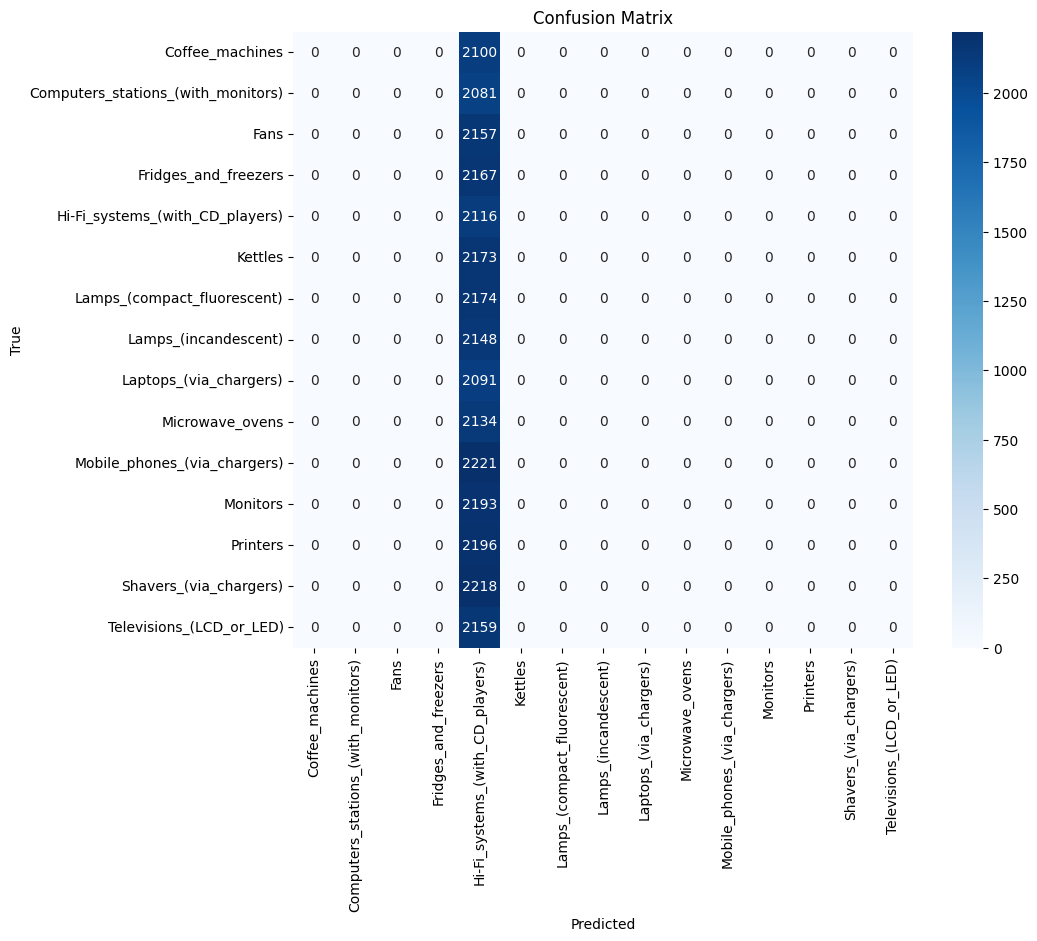

In [12]:
# Predict the labels for the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [13]:
# # Save the trained model and the scaler for future use
# model.save('new-model1.0.4.keras')
# scaler = StandardScaler().fit(X_train)
# joblib.dump(scaler, 'new-scaler1.0.4.pkl')